## Parabola example
This example is designed to evaluate the accuracy of our membrane force calculation using the coordinates of a parabolic function. Specifically, it examines how well the original force distribution can be recovered when small noise is added to the initial coordinates. The process is outlined as follows:

1. Sample `N_node` coordinate from the parabola function, $y = h x^2$. Add Gaussian noise, $\mathcal{N}(0, \sigma_\mathrm{noise})$, to every sampled point in both $x$ and $y$ directions. 
2. Based on the sampled points, interpolate the curve using B-spline function. Resample `n_vertices` points evenly from the interpolated curve. The interpolation is done by minimizing the following objective function, $J = \sum^N (y_i - S(x_i))^2 + s \cdot R(S)$. Here, $(x_i, y_i)$ is the originally sampled coordinate, $S$ is the B-spline function, and $R(S) = \int (S'')^2 ds$ is the smoothing term.
3. Relax the curve based on the custom membrane energy, $E = E_\mathrm{bend} + E_\mathrm{surf} + E_\mathrm{reg}$. Here, $E_\mathrm{bend} = \kappa_b \int_C H^2 ds$ is the bending energy, $E_\mathrm{surf} = \sigma \int_C ds$ is the surface energy, and $E_\mathrm{reg} = \kappa_r \sum (\frac{\Delta s - \langle \Delta s \rangle}{\langle \Delta s \rangle})^2$ is the regularization energy. The relaxation was performed by forward Eulear method.
4. Calculated the membrane force, $\vec{f}_i = \partial E_\mathrm{mem}/\partial \vec{r}_i$, based on a membrane energy, $E_\mathrm{mem} = E_\mathrm{bend} + E_\mathrm{surf}$. The partial derivative was numerically solved by JAX auto-diff.

In [9]:
# Parabola with noise

from sample import make_parabola
from variation_relax import resample, relax_bending
import os
import numpy as np


## Parameters ##
N_node = 100      # number of vertices on the original parabola
L_etoe = 100      # end-to-end distance of the parabola
height = 50       # height of the parabola
noise_level = 1   # noise added to the oridinal parabola coordinate
n_vertices = 100  # number of vertices to resample after b-spline smoothing
k_val = 3         # degree of b-spline polynominal 
s_val = 100       # coefficient of the data smoothing term


s_val_values = [1, 10, 100, 1000, 10000]
# n_iter_values = [1e2, 1e3, 1e4, 1e5, 1e6]


# Calculating the original parabola coordinate with noise
ori_coords = make_parabola(N_node = N_node, L_etoe = L_etoe, height = height, point_dist = "unif", noise_level = noise_level)
ori_coords = ori_coords[ori_coords[:, 0].argsort()]


for s_val in s_val_values:
# for n_iter in n_iter_values:

    params = {
        "Kb" : 10,   # bending modulus
        "Ksg": 10,   # tension modulus
        "Ksl": 10,   # regularization term
        "dt": 1e-5,  # time step for forward Eulear
        # "n_iter": int(8e2), # debug
        "n_iter": int(1e5),   # total iteration of forward Eulear
        # "n_iter": int(n_iter), 
        "boundary": "pinned",  # boundary condition
    }

    # Smooth the curve by b-spline and resample n_vertices coordinates
    coords, _ = resample(ori_coords, n_vertices, s_val, k_val)

    # Relax the curve by forward Eulear based on membrane energy
    relaxed_coords = relax_bending(coords, **params)
    # relaxed_coords = relax_bending(ori_coords, **params)

    # Storing data
    file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
    # file_path = os.path.join(f"dat/spline_test", f"smooth_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
    # file_path = os.path.join(f"dat/spline_test", f"relax_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_t{n_iter}.npz")

    np.savez(file_path, coords = relaxed_coords, ori_coords = ori_coords)
    # np.savez(file_path, coords = coords, ori_coords = ori_coords)



Energy relaxation:   0%|          | 0/100 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/10000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/100000 [00:00<?, ?it/s]

Energy relaxation:   0%|          | 0/1000000 [00:00<?, ?it/s]

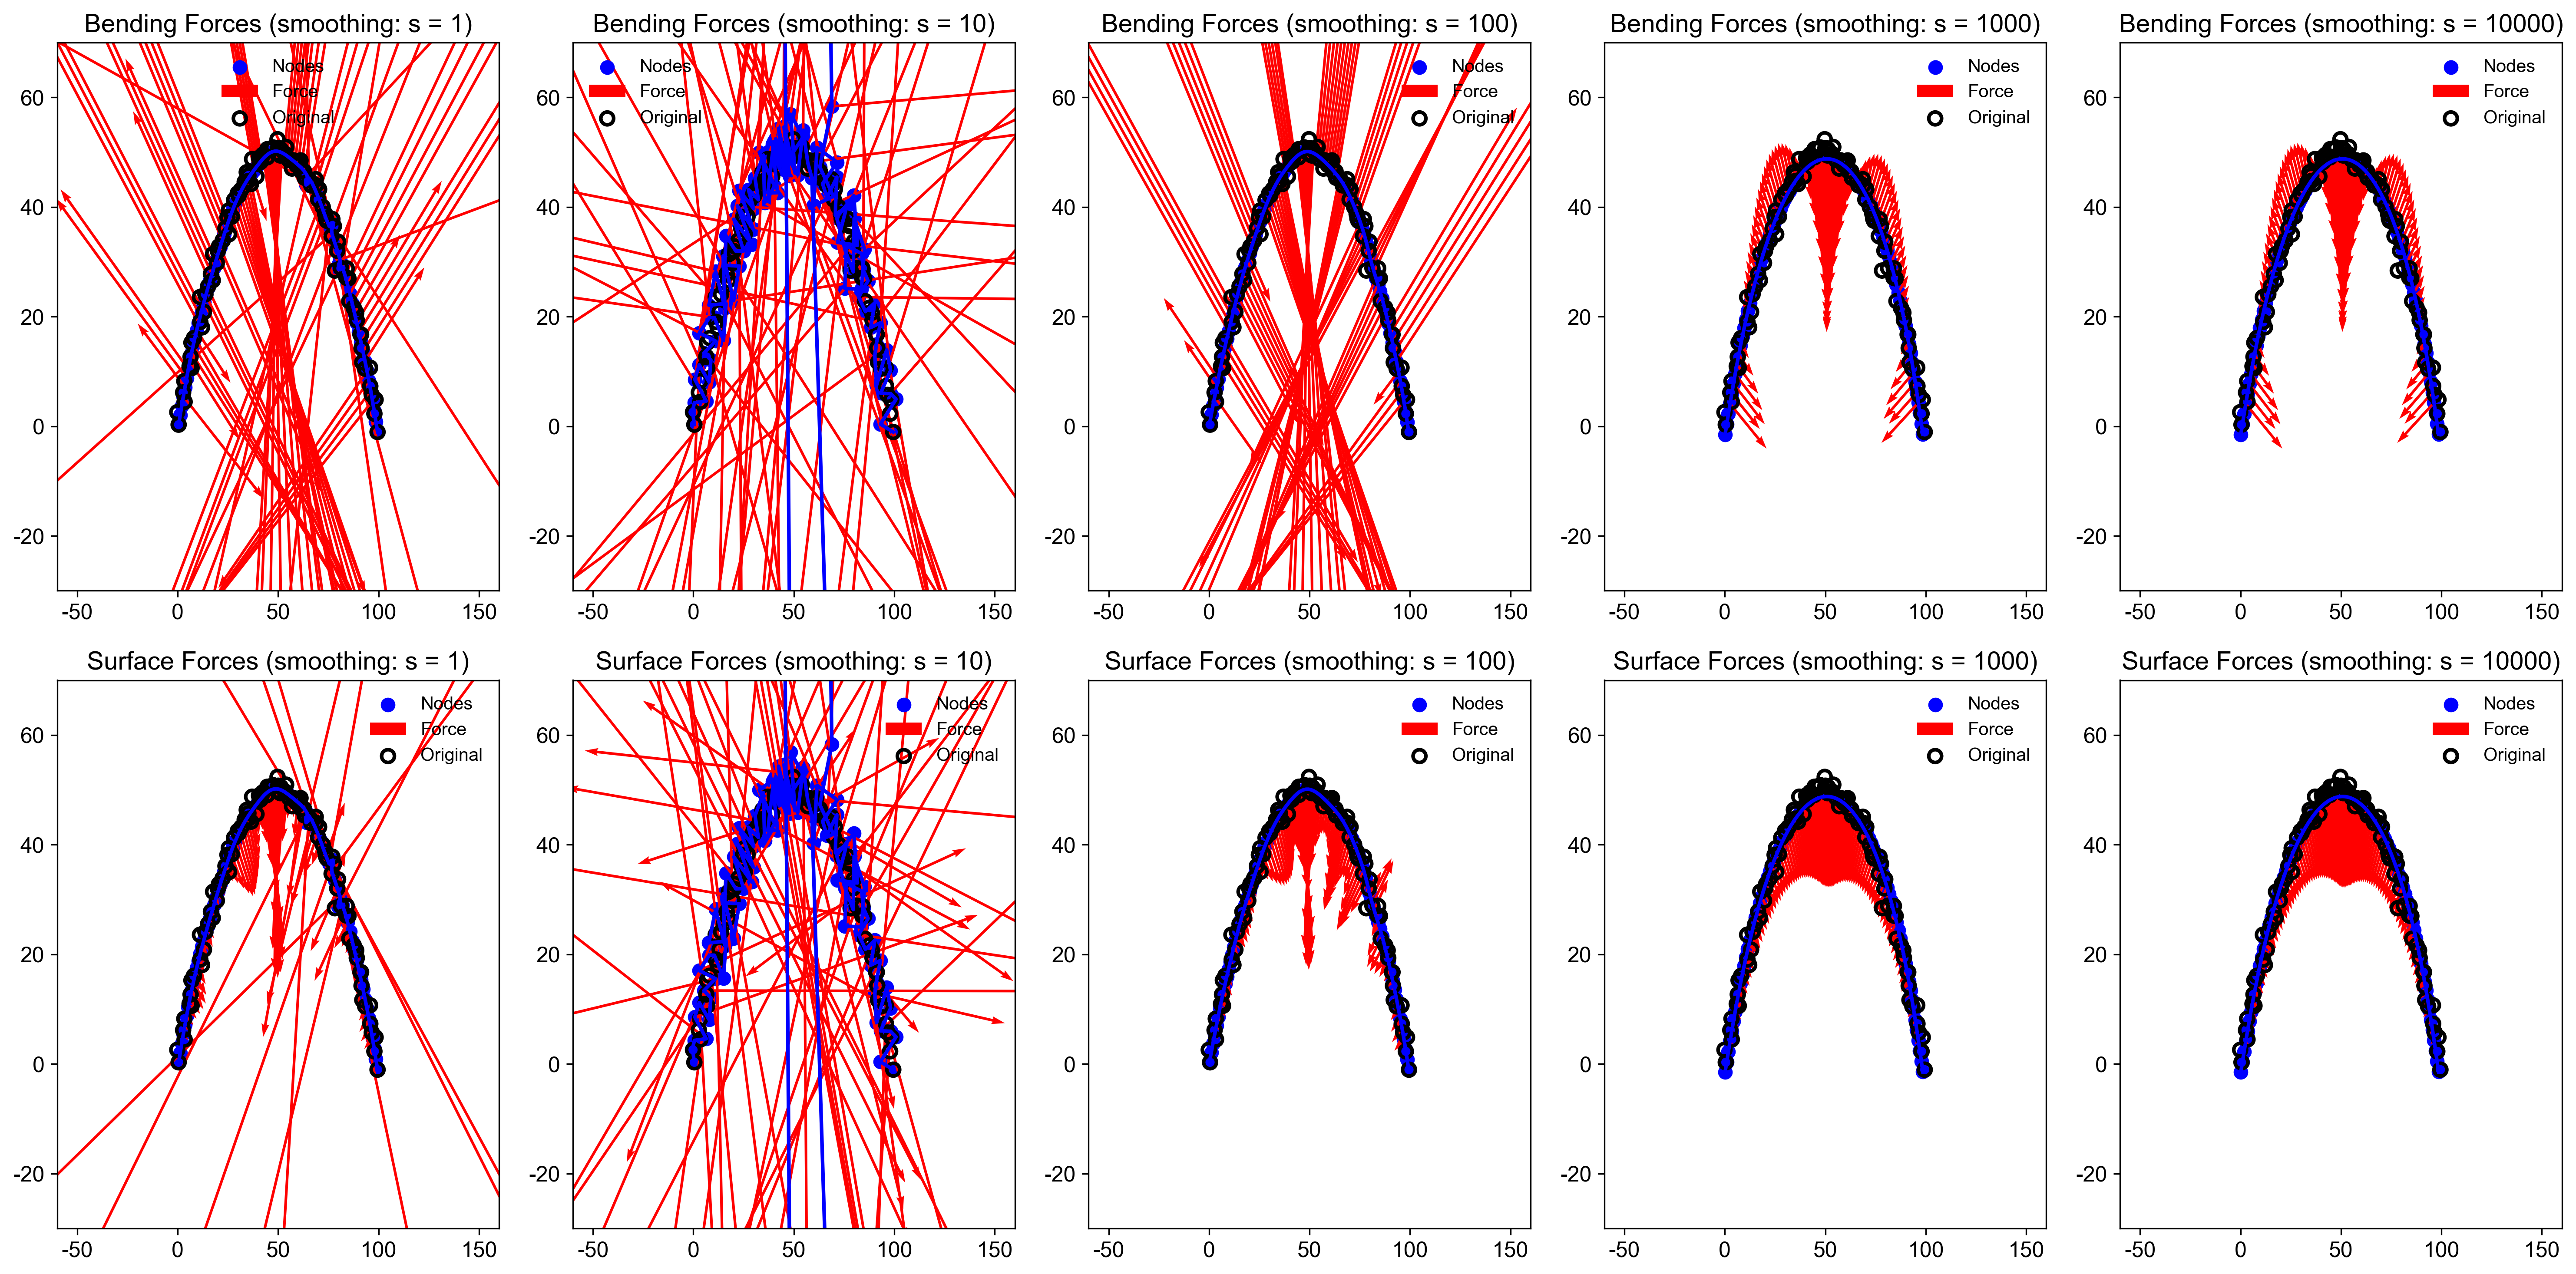

In [3]:
# Plotting data side by side

from variation_run import get_force_density
from sample import make_parabola, plot_parabola_ax
import matplotlib.pyplot as plt
import numpy as np
import os


## Parameters for force calculation
parameters = {
    "Kb":  100 / 4,   # Bending modulus
    "Ksg": 0.5,       # Global stretching modulus
    "Ksl": 0,
    "boundary": "fixed"
}

N_node = 100
noise_level = 1
n_vertices = 100
k_val = 3
s_val_values = [1, 10, 100, 1000, 10000]
# n_iter_values = [1e2, 1e3, 1e4, 1e5, 1e6]

fig, axes = plt.subplots(2, len(s_val_values), figsize=(20, 10))  # 2 rows for bend/surf, columns for mesh sizes
# fig, axes = plt.subplots(2, len(n_iter_values), figsize=(20, 10))  # 2 rows for bend/surf, columns for mesh sizes

for idx, s_val in enumerate(s_val_values):
# for idx, n_iter in enumerate(n_iter_values):

    file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
    # file_path = os.path.join(f"dat/spline_test", f"smooth_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
    # file_path = os.path.join(f"dat/spline_test", f"relax_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_t{n_iter}.npz")
    data = np.load(file_path)
    coords = data['coords']
    ori_coords = data['ori_coords']
    force = get_force_density(parameters, coords)

    # Plot Bending Force (row 0)
    plot_parabola_ax(coords, force[0], ax=axes[0, idx], s_val=s_val, force_type="Bending Forces", scale=10, ori_coords = ori_coords)
    # plot_parabola_ax(coords, force[0], ax=axes[0, idx], n_iter=n_iter, force_type="Bending Forces", scale=10, ori_coords = ori_coords)
    
    # Plot Surface Force (row 1)
    plot_parabola_ax(coords, force[1], ax=axes[1, idx], s_val=s_val, force_type="Surface Forces", scale=100, ori_coords = ori_coords)
    # plot_parabola_ax(coords, force[1], ax=axes[1, idx], n_iter=n_iter, force_type="Surface Forces", scale=100, ori_coords = ori_coords)    


plt.tight_layout()
# plt.savefig(f"figures/spline_test/force_n{N_node}_{noise_level:.2f}".replace('.', '')+ f"_n{n_vertices:03d}_k{k_val}.png", dpi=300)
# plt.savefig(f"figures/spline_test/smooth_force_n{N_node}_{noise_level:.2f}".replace('.', '')+ f"_n{n_vertices:03d}_k{k_val}.png", dpi=300)
# plt.savefig(f"figures/spline_test/relax_force_n{N_node}_{noise_level:.2f}".replace('.', '')+ f"_n{n_vertices:03d}.png", dpi=300)
plt.show()


## Testing code below
not important

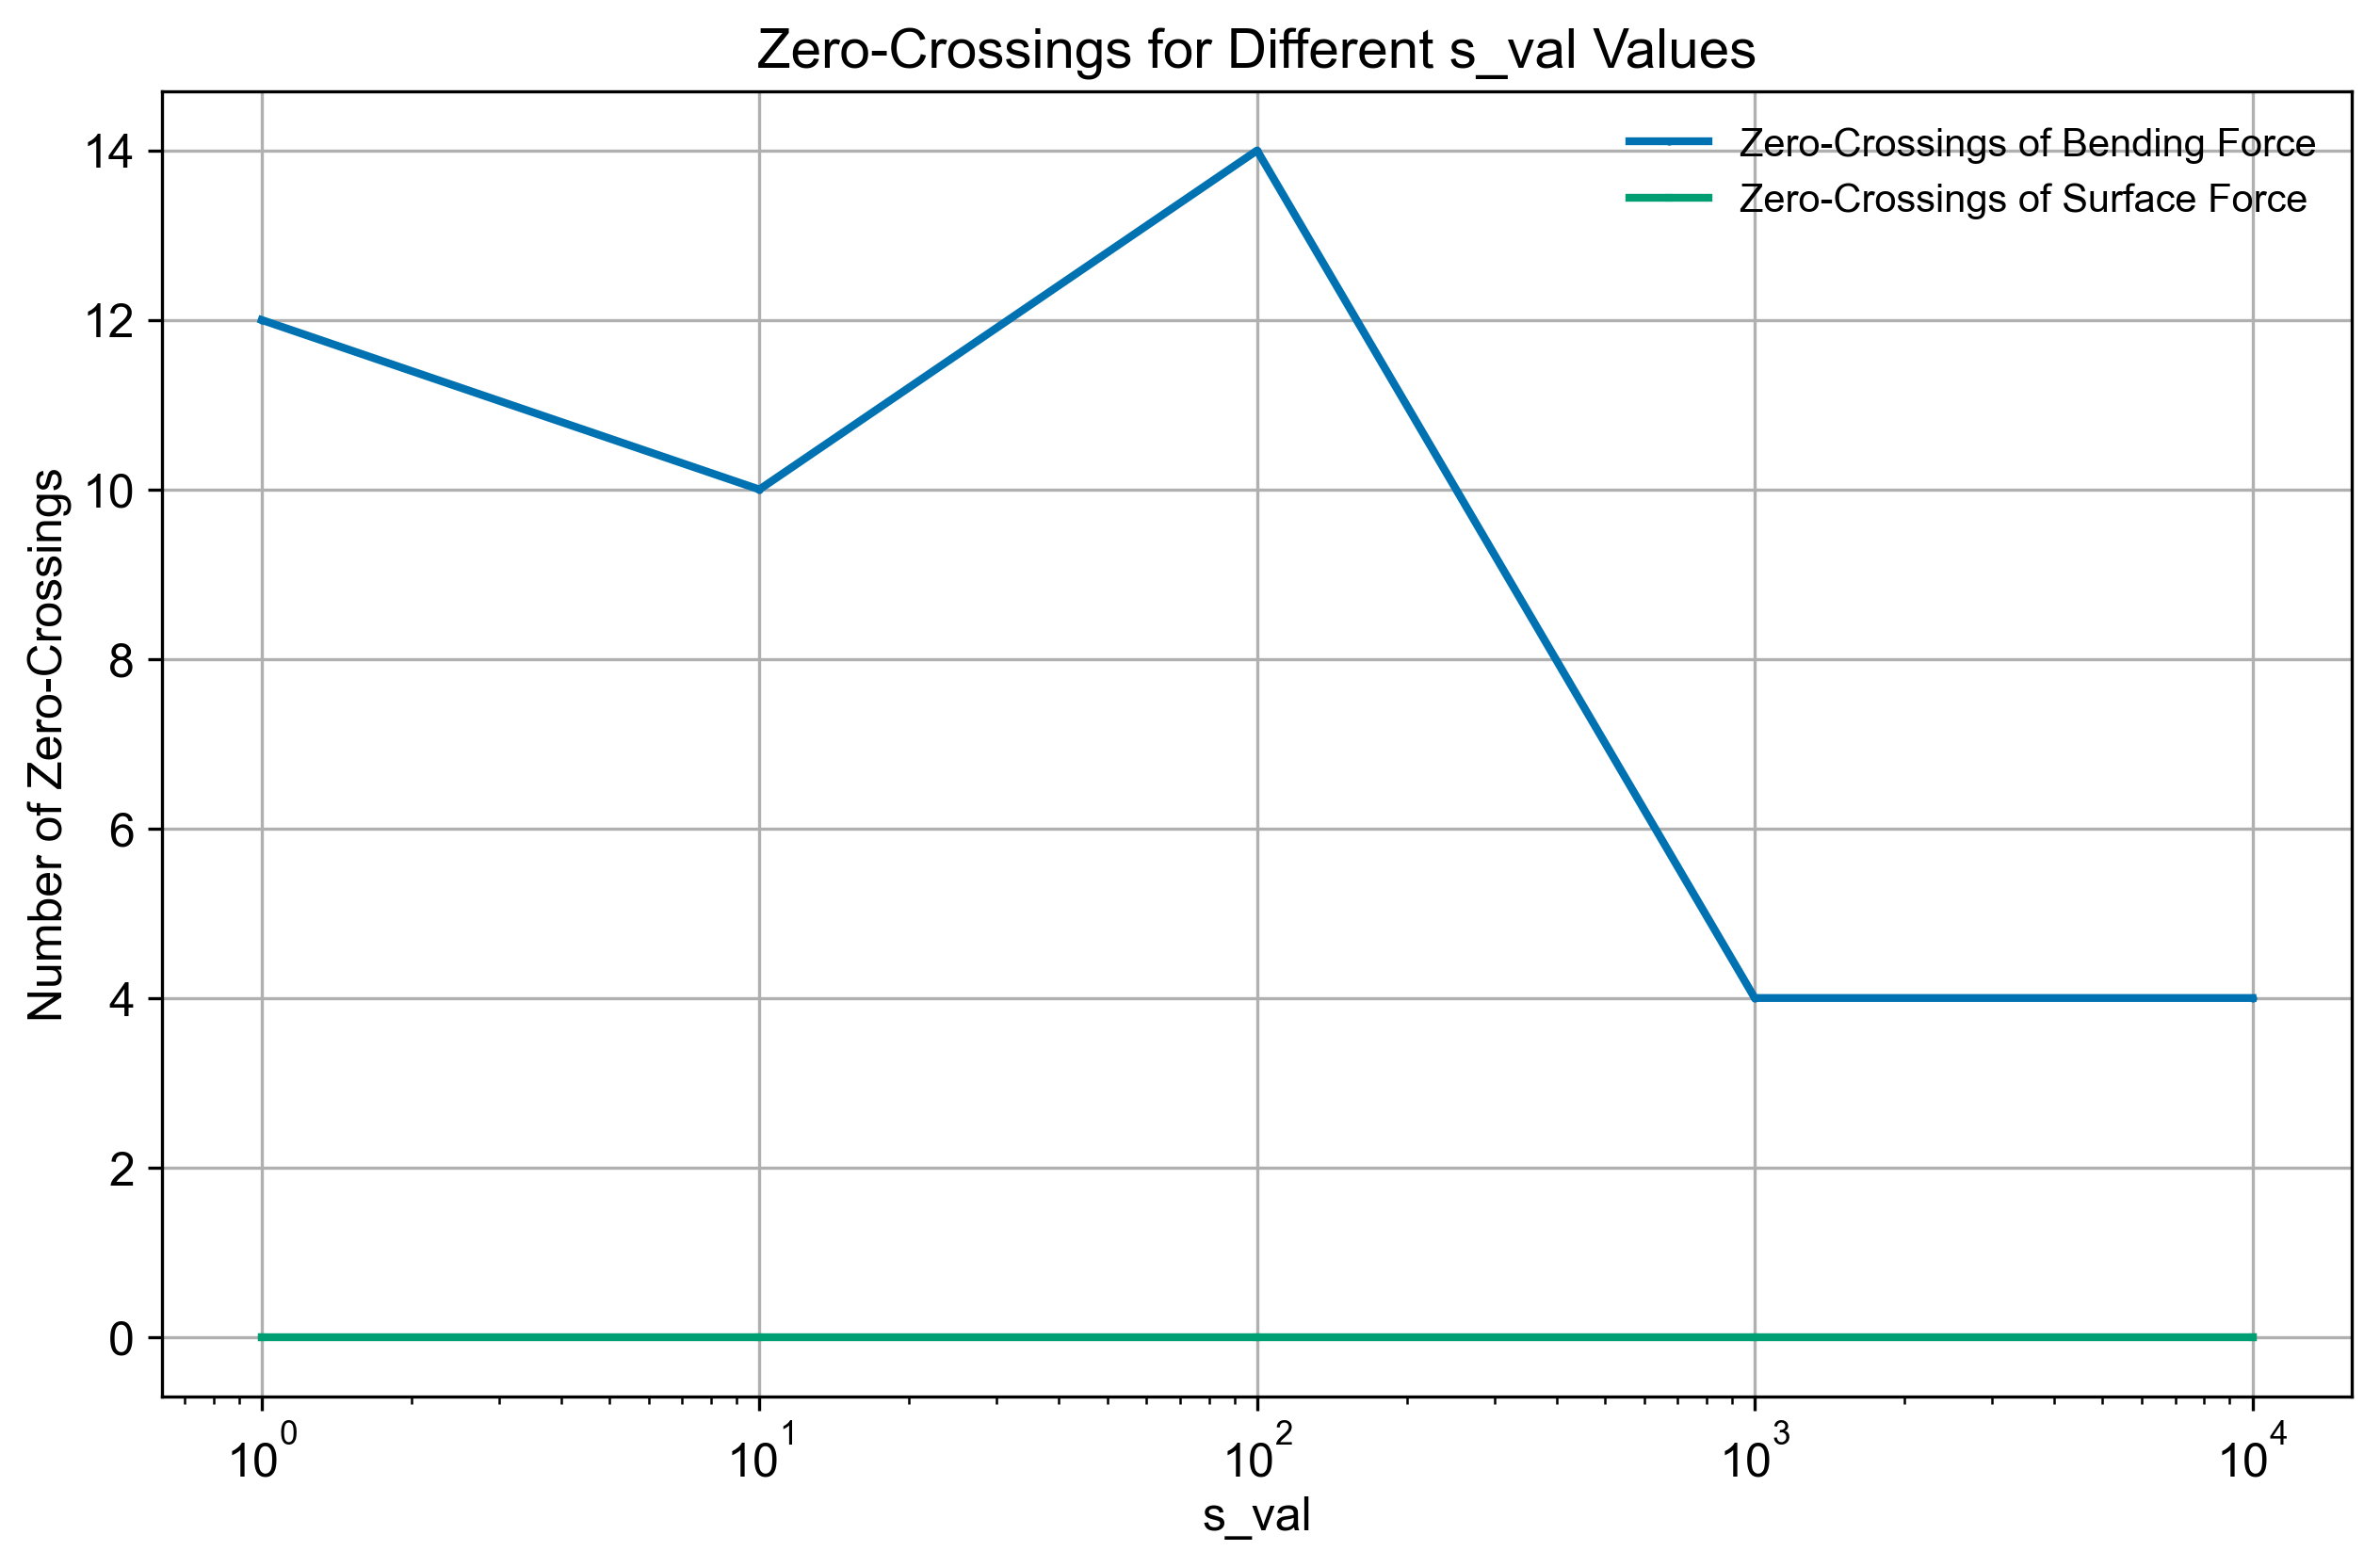

In [19]:
from sample import count_zero_crossings, plot_norm_side_by_side
from variation_run import get_force_density, get_force
from automembrane.geometry import OpenPlaneCurveGeometry
import numpy as np
import matplotlib.pyplot as plt
import os

N_node = 100
n_vertices = 50
noise_level = 1

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    # "Ksg": 0,    # Global stretching modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

s_val_values = [1, 10, 100, 1000, 10000]
zero_cross_bend = []
zero_cross_surf = []

for s_val in s_val_values:

    file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}.npz")
    data = np.load(file_path)
    coords = data['coords']

    forces = get_force(parameters, coords)
    normals = OpenPlaneCurveGeometry.vertex_normal(coords)

    dot_product = np.einsum('ij,ij->i', forces[0,], normals)
    count_bend = count_zero_crossings(dot_product)
    zero_cross_bend.append(count_bend)

    # dot_product = np.einsum('ij,ij->i', forces[1,], normals)
    # count_surf = count_zero_crossings(dot_product)
    # zero_cross_surf.append(count_surf)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(s_val_values, zero_cross_bend, marker='o', label='Zero-Crossings of Bending Force')
plt.plot(s_val_values, zero_cross_surf, marker='s', label='Zero-Crossings of Surface Force')

# Labels and title
plt.xscale('log')  # Use a logarithmic scale for s_val_values
plt.xlabel('s_val')
plt.ylabel('Number of Zero-Crossings')
plt.title('Zero-Crossings for Different s_val Values')
plt.legend()
plt.grid(True)
# plt.savefig(f"figures/mesh_test/normal_force_para_noise_n{N_node}.png", dpi=300)
plt.show()




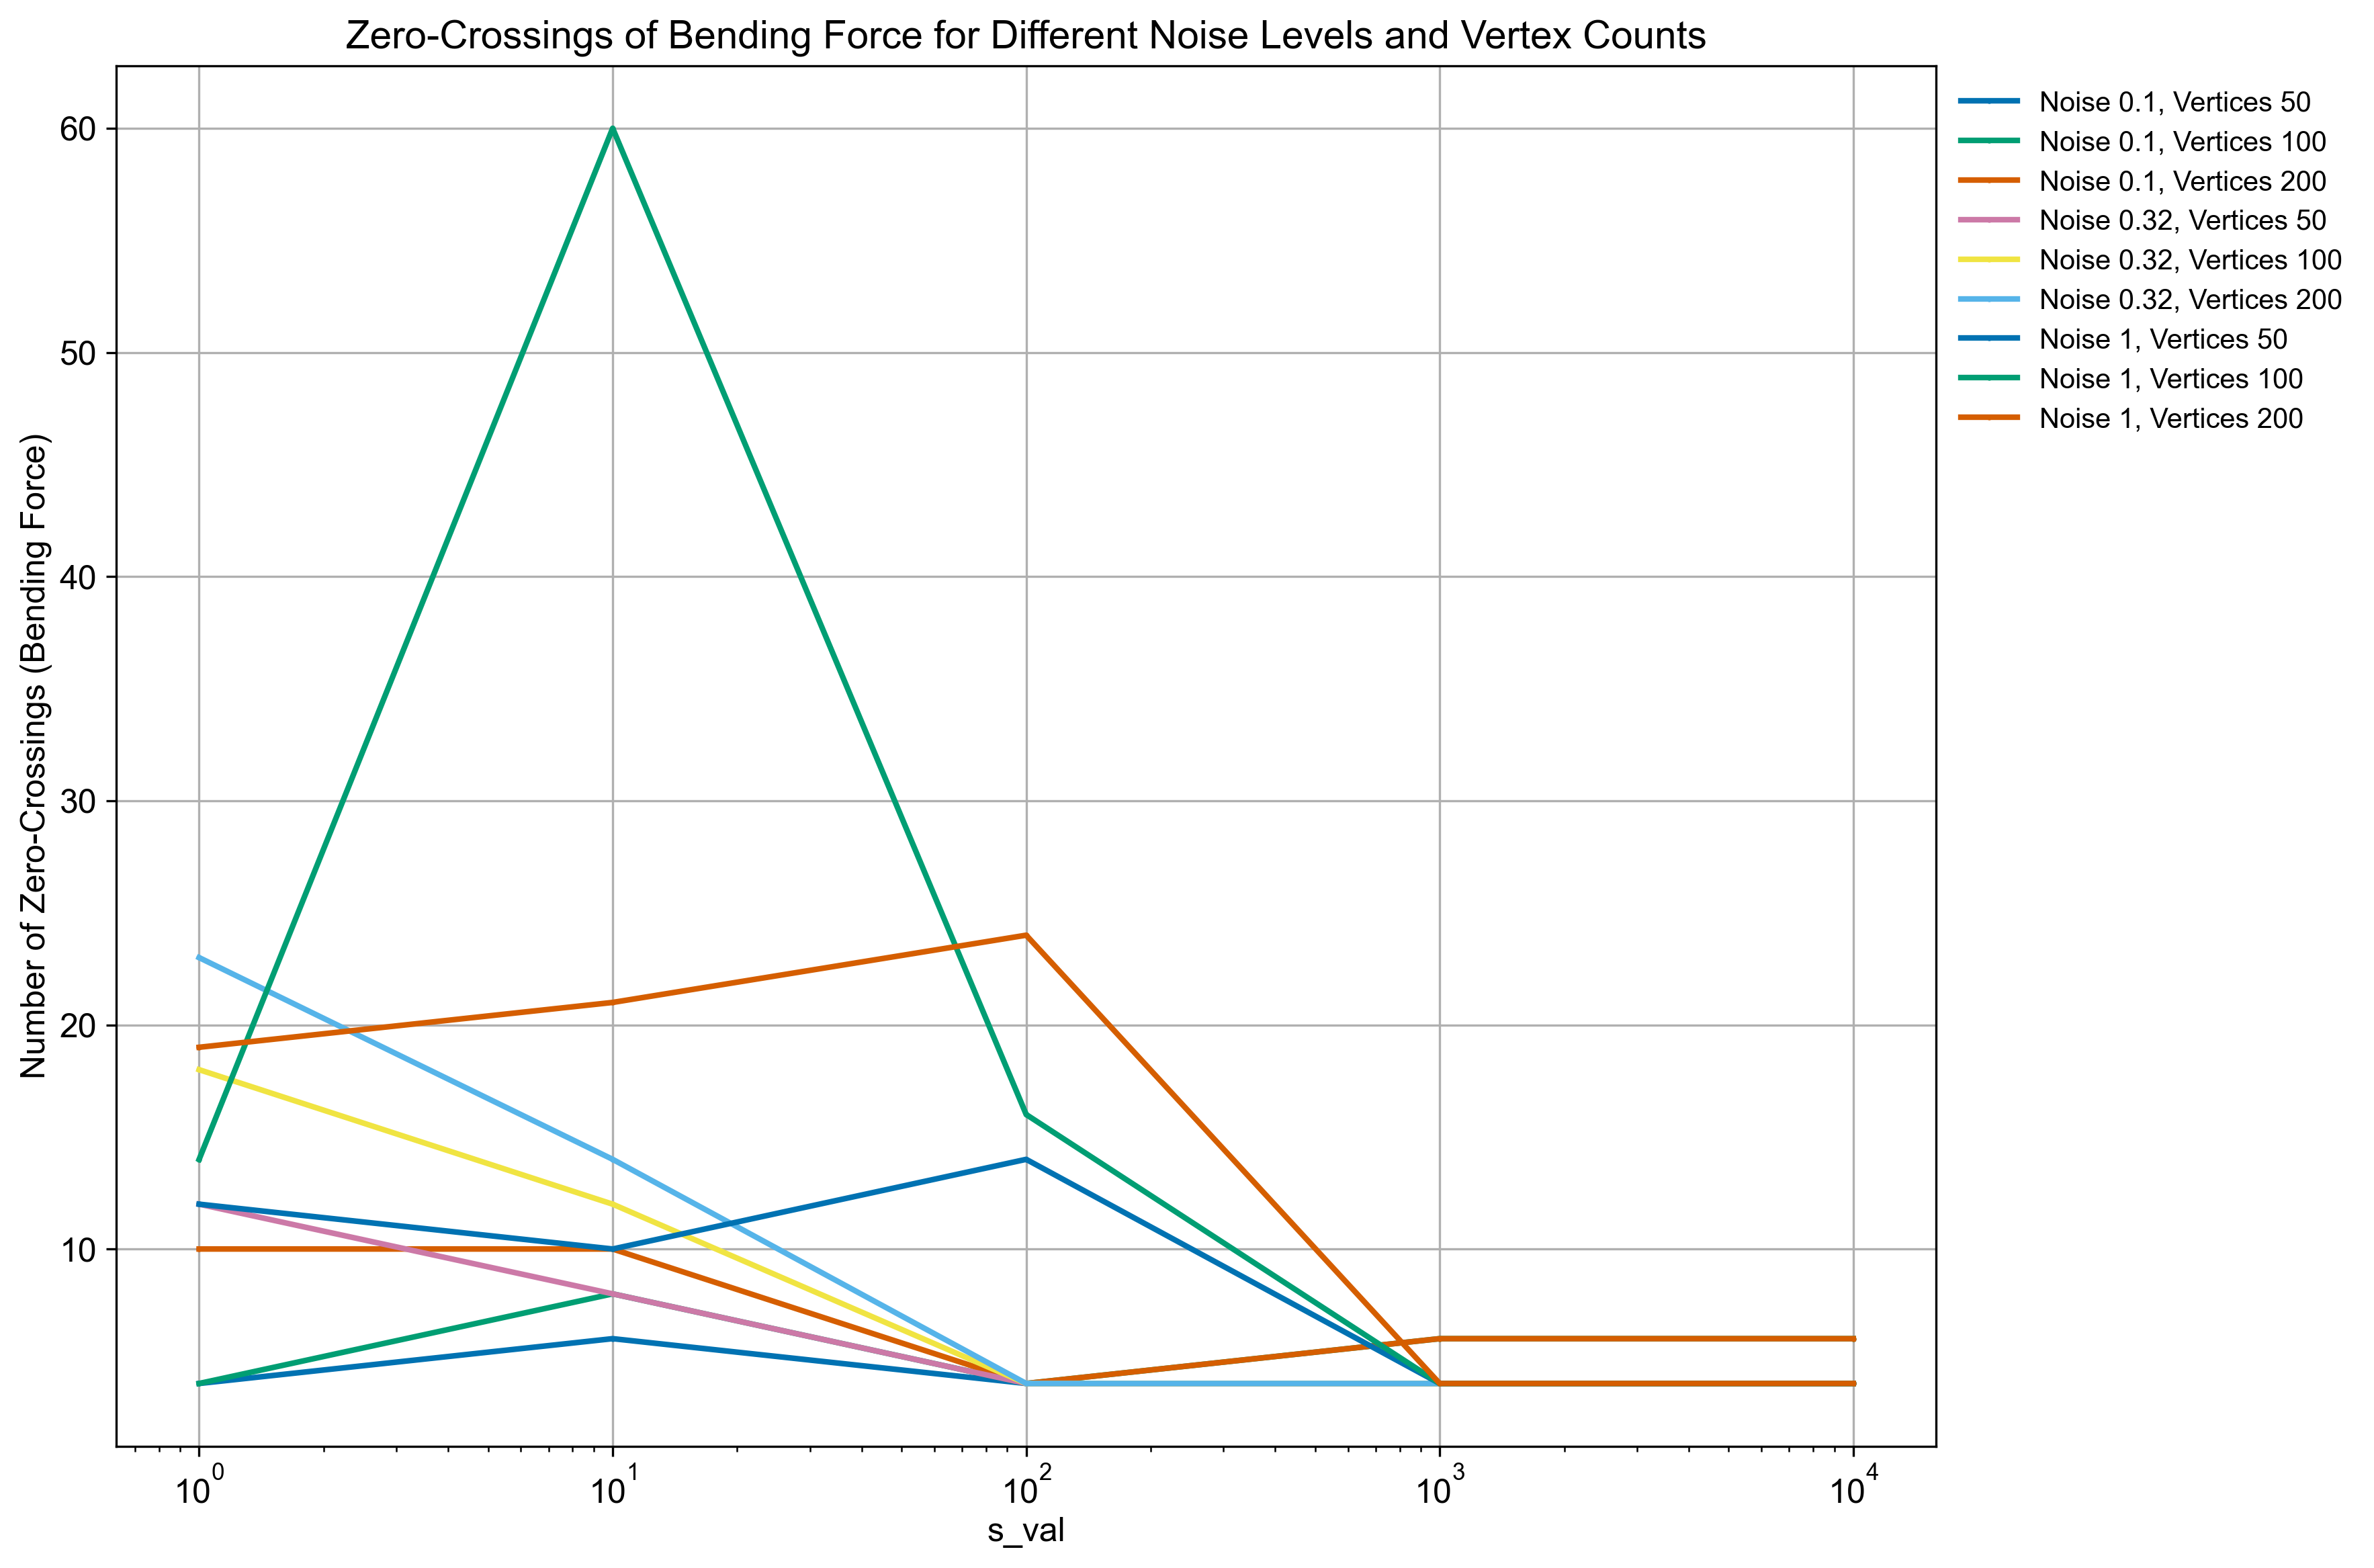

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sample import count_zero_crossings
from variation_run import get_force
from automembrane.geometry import OpenPlaneCurveGeometry

# Parameters
N_node = 100
noise_levels = [0.1, 0.32, 1]  # Multiple noise levels
n_vertices_list = [50, 100, 200]  # Different numbers of vertices

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,       # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

s_val_values = [1, 10, 100, 1000, 10000]

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate over noise levels and vertex counts
for noise_level in noise_levels:
    for n_vertices in n_vertices_list:
        zero_cross_bend = []

        for s_val in s_val_values:
            # Construct the file path
            file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}.npz")
            
            # Load data
            data = np.load(file_path)
            coords = data['coords']
            
            # Compute forces and dot product for bending force
            forces = get_force(parameters, coords)
            normals = OpenPlaneCurveGeometry.vertex_normal(coords)
            dot_product = np.einsum('ij,ij->i', forces[0,], normals)
            count_bend = count_zero_crossings(dot_product)
            
            # Append zero-crossing count for bending force
            zero_cross_bend.append(count_bend)

        # Plot zero-crossing data for the current noise level and vertex count
        plt.plot(s_val_values, zero_cross_bend, marker='o', label=f'Noise {noise_level}, Vertices {n_vertices}')

# Plot settings
plt.xscale('log')  # Use a logarithmic scale for s_val_values
plt.xlabel('s_val')
plt.ylabel('Number of Zero-Crossings (Bending Force)')
plt.title('Zero-Crossings of Bending Force for Different Noise Levels and Vertex Counts')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


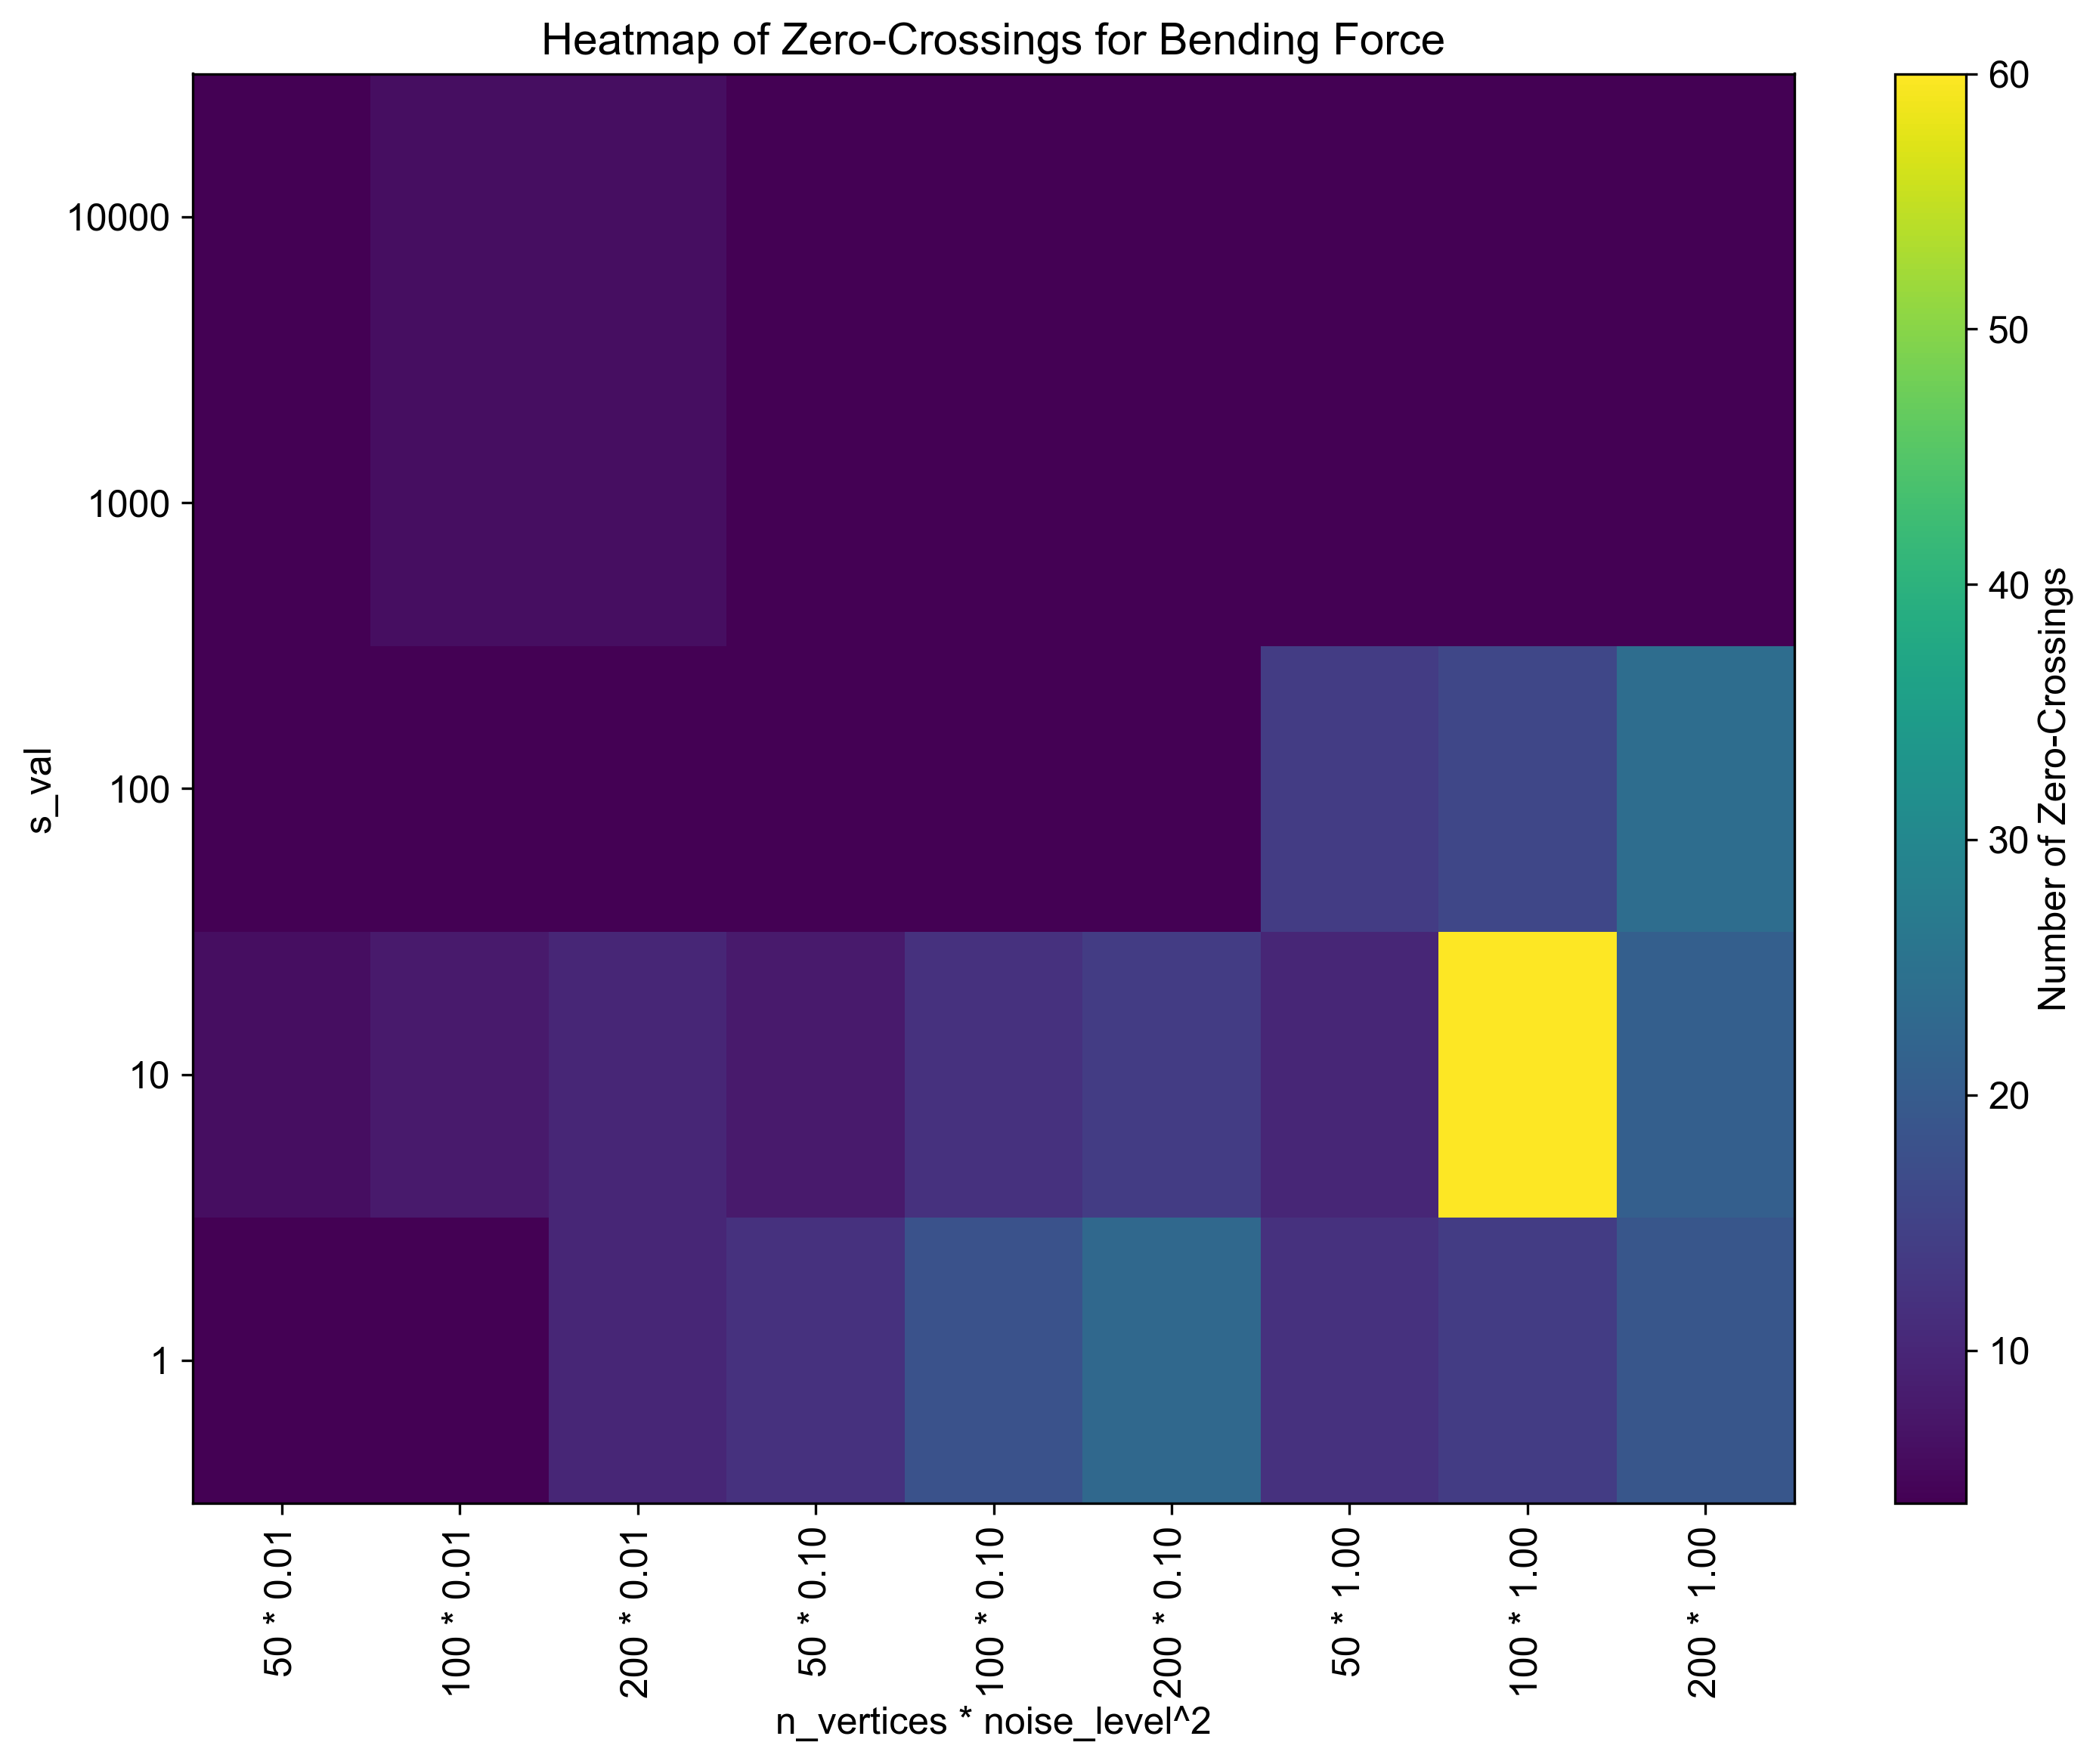

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sample import count_zero_crossings
from variation_run import get_force
from automembrane.geometry import OpenPlaneCurveGeometry

# Parameters
N_node = 100
noise_levels = [0.1, 0.32, 1]  # Multiple noise levels
n_vertices_list = [50, 100, 200]  # Different numbers of vertices
s_val_values = [1, 10, 100, 1000, 10000]

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,       # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

# Prepare data for the heatmap
x_values = []  # x-axis values: n_vertices * noise_level^2
y_values = s_val_values  # y-axis values: s_val
heatmap_data = []

# Iterate over noise levels and vertex counts
for noise_level in noise_levels:
    for n_vertices in n_vertices_list:
        zero_cross_bend_row = []
        x_val = n_vertices * (noise_level ** 2)  # Compute x-axis value
        x_values.append(x_val)
        
        for s_val in s_val_values:
            # Construct the file path
            file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}.npz")
            
            # Load data
            data = np.load(file_path)
            coords = data['coords']
            
            # Compute forces and dot product for bending force
            forces = get_force(parameters, coords)
            normals = OpenPlaneCurveGeometry.vertex_normal(coords)
            dot_product = np.einsum('ij,ij->i', forces[0,], normals)
            count_bend = count_zero_crossings(dot_product)
            
            # Append zero-crossing count for bending force
            zero_cross_bend_row.append(count_bend)
        
        # Store the zero-crossing data for the current configuration
        heatmap_data.append(zero_cross_bend_row)

# Convert the heatmap data to a NumPy array
heatmap_data = np.array(heatmap_data)

# Create the heatmap plot
plt.figure(figsize=(10, 8))
im = plt.imshow(heatmap_data.T, aspect='auto', cmap='viridis', origin='lower')

# Labeling
plt.colorbar(im, label='Number of Zero-Crossings')
plt.xlabel('n_vertices * noise_level^2')
plt.ylabel('s_val')
plt.title('Heatmap of Zero-Crossings for Bending Force')

# X-axis tick labels
x_labels = [f'{nv} * {nl**2:.2f}' for nl in noise_levels for nv in n_vertices_list]
plt.xticks(ticks=np.arange(len(x_values)), labels=x_labels, rotation=90)

# Y-axis tick labels
plt.yticks(ticks=np.arange(len(s_val_values)), labels=s_val_values)

# Display the plot
plt.tight_layout()
plt.show()


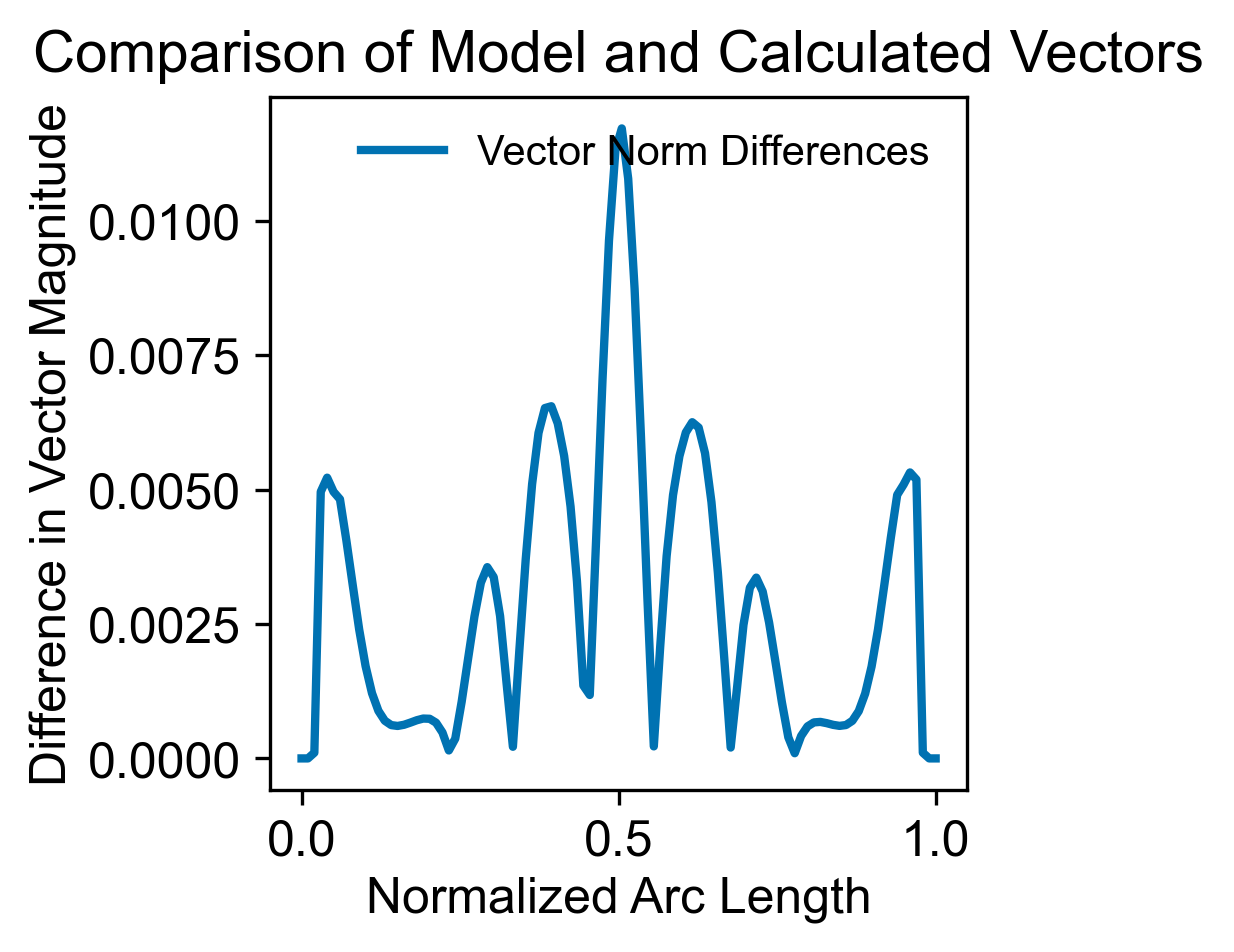

(array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.72727273, 0.73

In [12]:
from error import align_and_compare_vectors
from sample import make_parabola
from variation_run import get_force_density
import numpy as np
import matplotlib.pyplot as plt
import os

parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,    # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

## model parameters
N_node_model = 200
L_etoe = 100
height = 50

## calculation parameters
N_node = 100
noise_level = 0.1
n_vertices = 100
k_val = 2
s_val = 100


## model forces
model_coords = make_parabola(N_node=N_node_model, L_etoe=L_etoe, height=height, point_dist="unif")
model_forces = get_force_density(parameters, model_coords)
model_forces = model_forces[0]

## calculated forces
file_path = os.path.join(f"dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
data = np.load(file_path)
calc_coords = data['coords']
calc_forces = get_force_density(parameters, calc_coords)
calc_forces = calc_forces[0]


align_and_compare_vectors(model_points=model_coords, model_vectors=model_forces, calc_points = calc_coords, calc_vectors=calc_forces, plot=True)




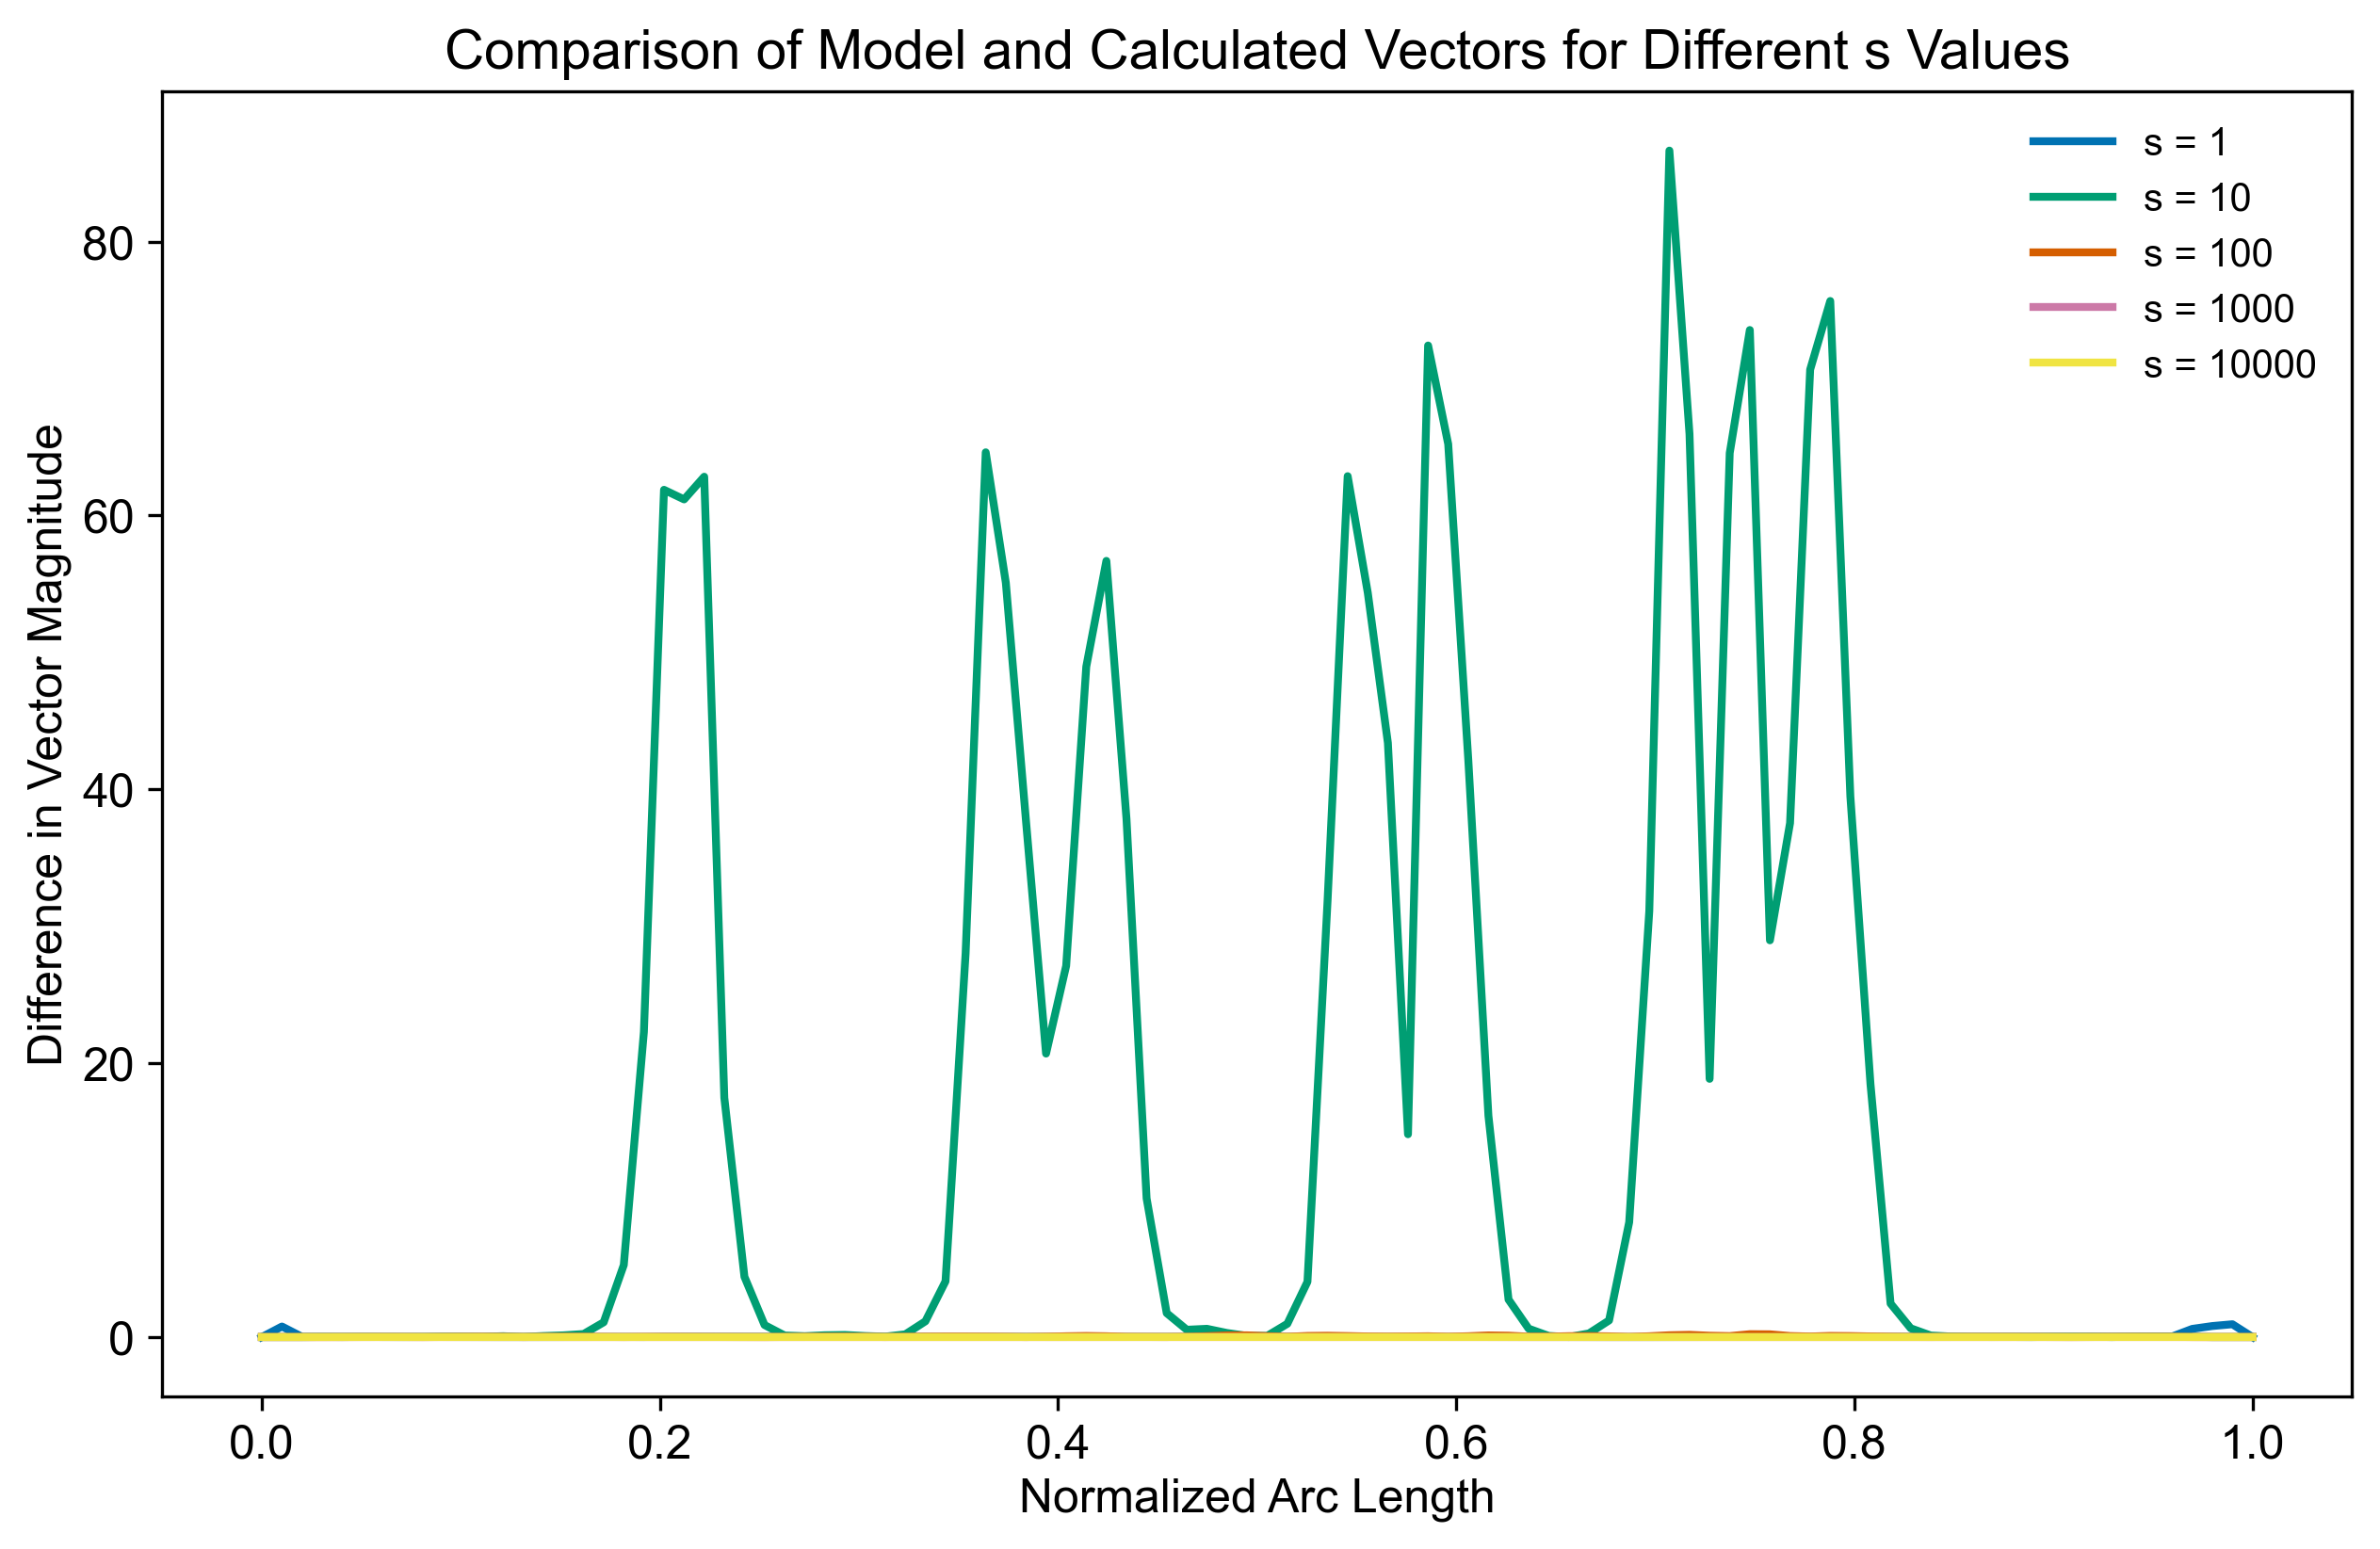

In [24]:
from error import align_and_compare_vectors
from sample import make_parabola
from variation_run import get_force_density
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameters
parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,       # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

# Model parameters
N_node_model = 200
L_etoe = 100
height = 50

# Calculation parameters
N_node = 100
noise_level = 1
n_vertices = 100
k_val = 2
s_vals = [1, 10, 100, 1000, 10000]
# s_vals = [100, 1000, 10000]

# Model forces
model_coords = make_parabola(N_node=N_node_model, L_etoe=L_etoe, height=height, point_dist="unif")
model_forces = get_force_density(parameters, model_coords)
model_forces = model_forces[0]


plt.figure(figsize=(10, 6))
for s_val in s_vals:
    # Calculated forces
    file_path = os.path.join("dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
    data = np.load(file_path)
    calc_coords = data['coords']
    calc_forces = get_force_density(parameters, calc_coords)
    calc_forces = calc_forces[0]

    common_u, differences = align_and_compare_vectors(model_points=model_coords, model_vectors=model_forces,
                                                      calc_points=calc_coords, calc_vectors=calc_forces, 
                                                      num_points=n_vertices, plot=False)
    plt.plot(common_u, differences, label=f's = {s_val}')

# Final plot adjustments
plt.xlabel('Normalized Arc Length')
plt.ylabel('Difference in Vector Magnitude')
plt.title('Comparison of Model and Calculated Vectors for Different s Values')
plt.legend()
file_path = os.path.join(f"figures/spline_test", f"error_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_k{k_val}.png")
plt.savefig(file_path, dpi=300)
plt.show()


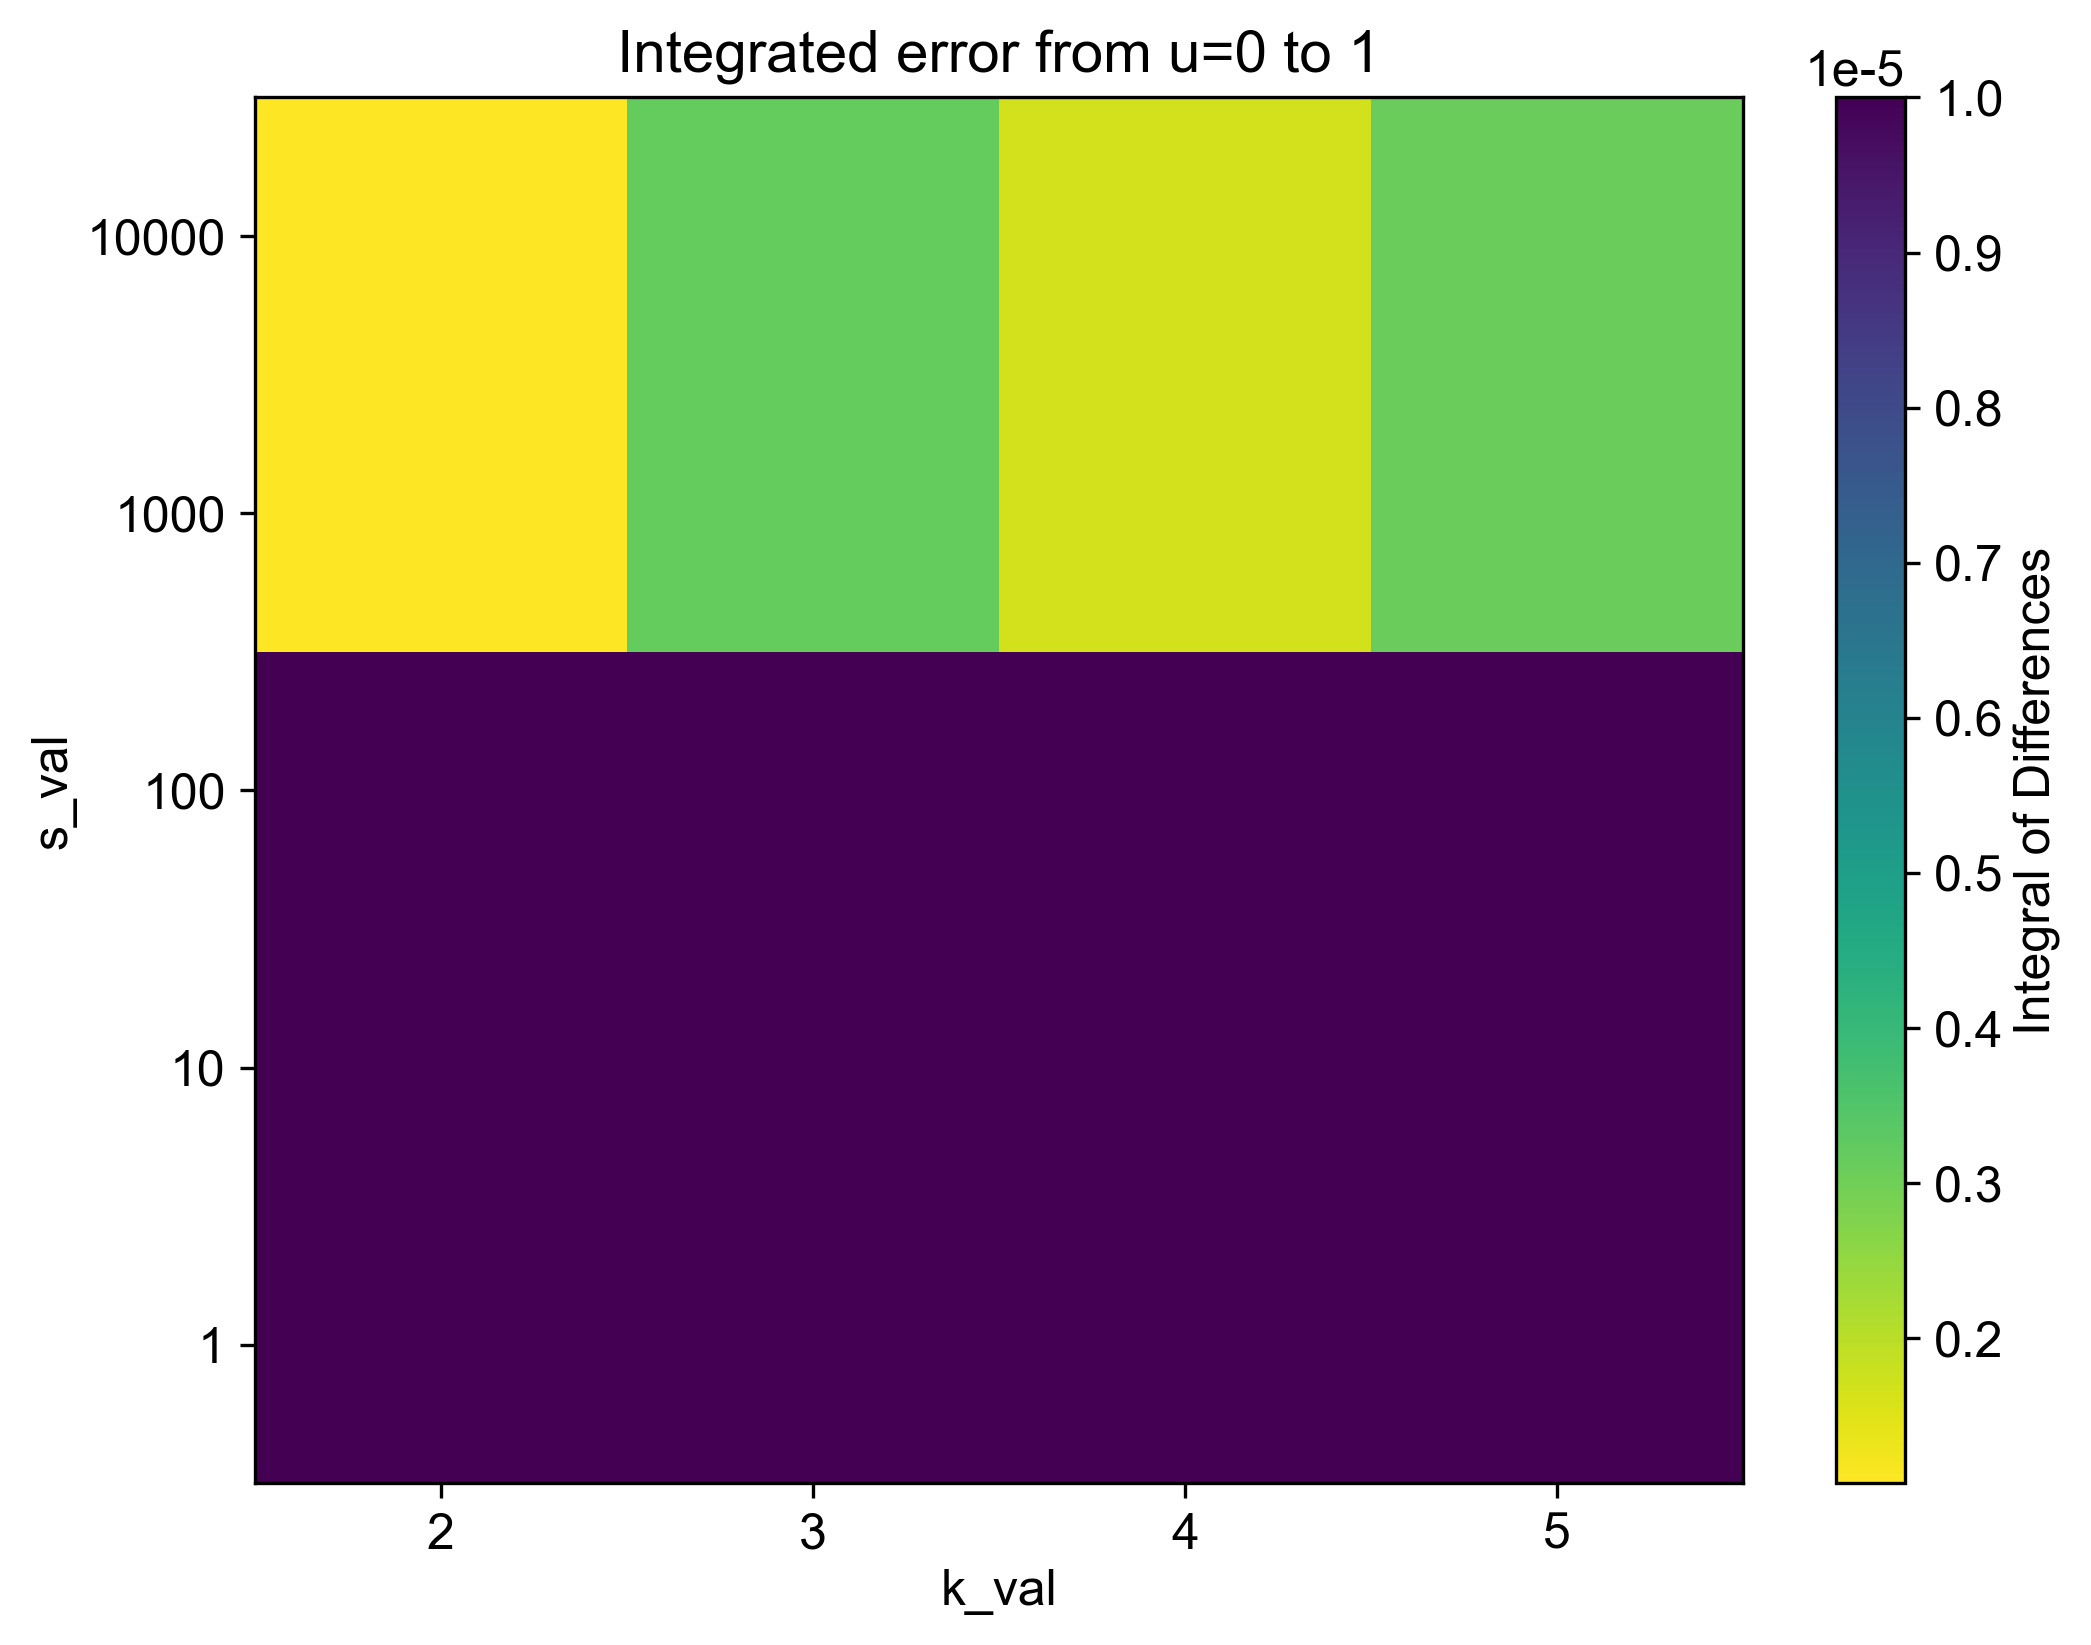

In [11]:
from error import align_and_compare_vectors
from sample import make_parabola
from variation_run import get_force_density
import numpy as np
import matplotlib.pyplot as plt
import os

# Parameters
parameters = {
    "Kb":  100 / 4,   # Bending modulus (pN nm)
    "Ksg": 0.5,       # Global stretching modulus (pN nm)
    "Ksl": 0,
    "boundary": "fixed"
}

# Model parameters
N_node_model = 200
L_etoe = 100
height = 50

# Calculation parameters
N_node = 100
noise_level = 1
n_vertices = 100
# k_vals = [3, 4, 5]
k_vals = [2, 3, 4, 5]
# k_vals = [3, 4]
s_vals = [1, 10, 100, 1000, 10000]


integral_matrix = np.zeros((len(s_vals), len(k_vals)))

# Model forces
model_coords = make_parabola(N_node=N_node_model, L_etoe=L_etoe, height=height, point_dist="unif")
model_forces = get_force_density(parameters, model_coords)
model_forces = model_forces[0]

# Loop over s_vals and k_vals
for i, s_val in enumerate(s_vals):
    for j, k_val in enumerate(k_vals):
        # Calculated forces
        file_path = os.path.join("dat/spline_test", f"n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}_s{s_val:03d}_k{k_val}.npz")
        data = np.load(file_path)
        calc_coords = data['coords']
        calc_forces = get_force_density(parameters, calc_coords)
        calc_forces = calc_forces[0]

        # Align and calculate vector differences
        common_u, differences = align_and_compare_vectors(model_points=model_coords, model_vectors=model_forces,
                                                          calc_points=calc_coords, calc_vectors=calc_forces, 
                                                          num_points=n_vertices, plot=False, add_weight=True)

        # Integrate the differences using Simpson's rule
        u_s = 0
        u_e = 1
        start_index = np.searchsorted(common_u, u_s)
        end_index = np.searchsorted(common_u, u_e)
        integral_of_differences = np.trapezoid(differences[start_index:end_index], common_u[start_index:end_index])
        
        integral_matrix[i, j] = integral_of_differences  # Store in matrix

# Plot heatmap
plt.figure(figsize=(8, 6))
# plt.imshow(integral_matrix, aspect='auto', cmap='viridis_r', origin='lower', vmin = 0, vmax=0.005)
plt.imshow(integral_matrix, aspect='auto', cmap='viridis_r', origin='lower', vmax=0.00001)
plt.colorbar(label='Integral of Differences')
plt.xticks(ticks=np.arange(len(k_vals)), labels=k_vals)
plt.yticks(ticks=np.arange(len(s_vals)), labels=s_vals)
plt.xlabel('k_val')
plt.ylabel('s_val')
plt.title(f'Integrated error from u={u_s} to {u_e}')
file_path = os.path.join(f"figures/spline_test", f"int_error_n{N_node}_{noise_level:.2f}".replace('.', '') + f"_n{n_vertices:03d}.png")
# plt.savefig(file_path, dpi=300)
plt.show()


In [7]:
print(.shape)


(200,)
